# Railgun Model

Thomas Jagielski and Duncan  Mazza

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import math

Assumptions:
- Constant lorentz force, which is dependent on:    

    - Constant current
    
    - The rails are made of iron (magnetic)
    
    - Rails are separated enough (by length w) relative to their diameter
    
    - Rails are long enough relative to their separation (w) so they can be treated by the equations as rails of infinite length.
    
    - Armature is made of copper (conductive)
    
    - Rails are cylindrical and wire-like (small diameter)
    
    - Uniform current density
    
    - Thin armature
    
    - Constant mu
    
    - No energy loss to magnetization
    
    - No energy lost to eddy currents
    
- Coefficient of drag for armature is constant and is 2

- Flow speed around armature equals the armatures velocity



In [2]:
num_sweeps = 15
angle_elevation = Params(angle_elevation = pi / 4);

In [3]:
params = Params(mass_proj = 0.145, #kg
                #mass_proj = 50, #kg
                rail_r = 0.01, #m
                rail_l = 3, #m
                arm_w = 0.9, #m in x axis
                arm_l = 0.01, #m in y axis
                arm_d = 0.02, #m in z axis
                w = 0.1, #m
                # mu = 1150, #T  
                mu = 10, 
                rho_cu = 8960, #g/m^3
                v_init = 0, #m/s
                y_init = 0, #m
                t_end = 1000,
                coef_fric = 0.36, #dimensionless, kinetic friction
                g = 9.8, #m/s*s
                angle_elevation = angle_elevation.angle_elevation, #radians; being swept
                cd = 2, # approximate drag coefficient of a rectangular box 
                rho_air = 1.225, # kg/m^3
                current = 1000 # amperes
               )
;

''

In [4]:
def make_system(params):
    """Make a system object.
    
    params: 
    
    returns: System object
    """

    unpack(params)
    
    mass_arm = (arm_w * arm_l * arm_d) * rho_cu

    # If coordinate system moves with the rails, then...
    # Unit vector in direction of rails:
    # rail_direc = Vector(0,1,0)
    # normal_rail = Vector(0,0,1)
    
    lorentz_force = ((mu * current**2)/(2 * np.pi)) * (math.log((rail_r + w) / rail_r))
    B = ((mu * current)/(2 * np.pi * w)) * (math.log((rail_r + w) / rail_r))
    arm_friction = coef_fric * (g * mass_arm * math.cos(angle_elevation))
    gravity_y_direc = g * mass_arm * math.sin(angle_elevation)
    front_area = arm_w * arm_d #m^2 frontal areaa of the armature 
    
    init = State(v=v_init, y=y_init)
    
    return System(params, lorentz_force=lorentz_force, mass_arm = mass_arm, B = B, arm_friction = arm_friction, 
                  gravity_y_direc = gravity_y_direc, front_area = front_area, init=init)

In [5]:
system = make_system(params);

In [6]:
def slope_func(state, t, system):
    
    unpack(system)
    v, y = state
    
    emf = B * v * w 
    # The u of the drag force equation will be set equal to velocity (v)
    air_resistance = 0.5 * rho_air * (v**2) * cd * front_area
    
    dvdt = (lorentz_force - emf - arm_friction - gravity_y_direc - air_resistance) / (mass_proj + mass_arm)
    dydt = v
        
    return dvdt, dydt

In [7]:
slope_func(system.init, 0, system)

(2171096.6306084436, 0.0)

In [8]:
def event_func(state, t, system):
    v, y = state
    return system.rail_l - y

In [9]:
results, details = run_ode_solver(system, slope_func, events = event_func, max_step=0.00001)
details

,values
sol,None
t_events,[[0.0034736844511860676]]
nfev,2090
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [10]:
results;

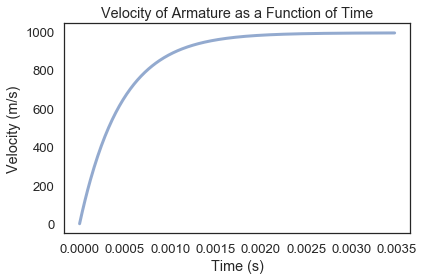

In [11]:
plot(results.v)

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)',
         title='Velocity of Armature as a Function of Time',
         legend=False)

### Projectile Motion 

Assumptions:
- The projectile is a baseball and follows the drag coefficient curve given by `data/baseball_drag.csv`
- No wind in any direction
- No angular velocity of the baseball

In [12]:
params_proj = Params(x = 0, #m 
                     g = 9.8, #m/s^2
                     mass = 145e-3, #kg
                     diameter = 73e-3, #m
                     rho = 1.2, #kg/m^3
                     C_d = 0.33,
                     angle = params.angle_elevation, #radians
                     velocity = get_last_value(results.v), #m / s
                     t_end = 200, #s
                     target_x = 320, #m
                     target_y = 0, #m
                     target_radius = 0.5 #m
                     )
;

''

In [31]:
def make_system_proj(params, params1):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(params.angle, velocity)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # define y
    y = math.sin(params.angle) * system.rail_l #m
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    return System(params, init=init, area=area, y=y)

In [32]:
system_proj = make_system_proj(params_proj, params)

,values
x,0
g,9.8
mass,0.145
diameter,0.073
rho,1.2
C_d,0.33
angle,0.785398
velocity,993.798
t_end,200
target_x,320


In [33]:
m = UNITS.meter
s = UNITS.second

baseball_drag = pd.read_csv('data/baseball_drag.csv')
baseball_drag.index = Quantity(baseball_drag['Velocity in mph'].values, UNITS.mph).to(m/s)
baseball_drag;

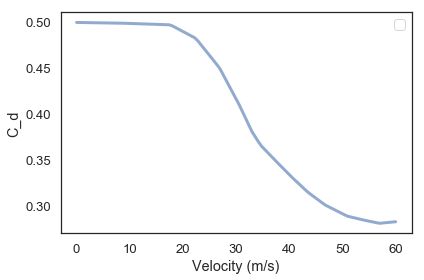

In [34]:
drag_interp = interpolate(baseball_drag['Drag coefficient'])
vs = linspace(0, 60, 101)
cds = drag_interp(vs)
plot(vs, cds)
decorate(xlabel = 'Velocity (m/s)', ylabel = 'C_d')

In [35]:
def drag_force(v, system):
    """finds drag force in the opposing direction to velocity
    
    v: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    
    unpack(system)
    C_d = drag_interp(v.mag)
    mag = -rho * v.mag ** 2 * C_d * area / 2
    direction = v.hat()
    f_drag = direction * mag
    return f_drag

In [36]:
def slope_func_proj(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    v = Vector(vx, vy)    
    a_drag = drag_force(v, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [37]:
slope_func_proj(system_proj.init, 0, system_proj)

(702.721098455984,
 702.721098455984,
 <Quantity(-9628.802796352897, 'dimensionless')>,
 <Quantity(-9638.602796352896, 'dimensionless')>)

In [38]:
def event_func_proj(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y

In [39]:
event_func_proj(system_proj.init, 0, system_proj)

2.121320343559643

In [40]:
system_proj = System(system_proj, drag_interp = drag_interp)
results_proj, details_proj = run_ode_solver(system_proj, slope_func_proj, 
                                            events = event_func_proj, max_step=0.05)
details_proj

,values
sol,None
t_events,[[15.87378873196279]]
nfev,1940
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [41]:
results_proj_int_x = interpolate(results_proj.x)
results_proj_int_y = interpolate(results_proj.y)

In [42]:
results_proj;

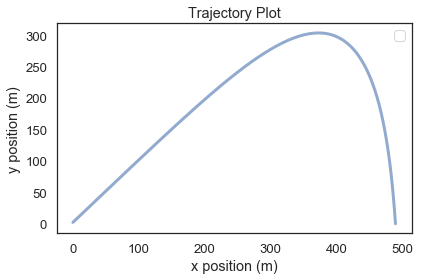

In [45]:
plot(results_proj.x, results_proj.y)

decorate(title='Trajectory Plot', 
         xlabel='x position (m)',
         ylabel='y position (m)')

In [46]:
def simulation(angle_elevation):
    params_new = Params(params, angle_elevation = angle_elevation)
    system = make_system(params_new)
    results_sim, details_sim = run_ode_solver(system, slope_func, events = event_func, max_step = 0.00001)
  
    params_proj_new = Params(params_proj, angle = params_new.angle_elevation, velocity = get_last_value(results_sim.v))
    system_proj = make_system_proj(params_proj_new, params_new)
    results_proj, details_proj = run_ode_solver(system_proj, slope_func_proj, 
                                            events = event_func_proj, max_step=0.1)
    return results_proj.x, results_proj.y

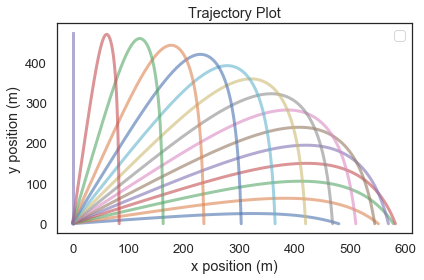

In [59]:
for i in range(0, num_sweeps): 
    angle_linspace = linspace(0.1, pi/2, num_sweeps)
    params.angle_elevation = angle_linspace[i]
    results_proj_x, results_proj_y = simulation(params.angle_elevation)
    plot(results_proj_x, results_proj_y)

decorate(title='Trajectory Plot', 
         xlabel='x position (m)',
         ylabel='y position (m)',
         )

In [67]:
# Assuming that the projectile is on the ground (y = 0):
def simulation_hitting_target(angle_elevation):
    params_new = Params(params, angle_elevation = angle_elevation)
    system = make_system(params_new)
    results_sim, details_sim = run_ode_solver(system, slope_func, events = event_func, max_step = 0.00001)
  
    params_proj_new = Params(params_proj, angle = params_new.angle_elevation, velocity = get_last_value(results_sim.v))
    system_proj = make_system_proj(params_proj_new, params_new)
    results_proj, details_proj = run_ode_solver(system_proj, slope_func_proj, 
                                            events = event_func_proj, max_step=0.1)
    return get_last_value(results_proj.x) - params_proj.target_x

In [68]:
fsolve(simulation_hitting_target, x0 = 1.05)
print('The angle from horizontal that will cause the projectile to hit the target is {} )

array([1.12326571])

In [63]:
simulation_hitting_target(1)

4.945890070133894e-14

### Sources

- Source for coeff fric: http://www.engineershandbook.com/Tables/frictioncoefficients.htm

- Source for drag coeff: https://www.engineeringtoolbox.com/drag-coefficient-d_627.html

- Source for railgun physics: http://citeseerx.ist.psu.edu/viewdoc/download?rep=rep1&type=pdf&doi=10.1.1.205.7739

- Source for air density: https://www.engineersedge.com/calculators/air-density.htm


In [55]:
params_proj.target_x

320.0